# Proposed Model - Hybrid (CF and CBF) Recomendation System

## Import Library

In [60]:
# Install required libraries
!pip install fuzzywuzzy
!pip install surprise
!pip install nltk
!pip install scipy
!pip install scikit-learn
!pip install Sastrawi

In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Import Dataset


In [62]:
!gdown 15IvPCBnM0d7EdV7_j5urms9cCwnSa9v7

# Load dataset
import pandas as pd
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
data = pd.read_csv(file_path)
data.head()

Downloading...
From: https://drive.google.com/uc?id=15IvPCBnM0d7EdV7_j5urms9cCwnSa9v7
To: /content/Tempat-Wisata-Toba-Preprocessing.csv
100% 8.99M/8.99M [00:00<00:00, 25.7MB/s]


,Unnamed: 0.1,Unnamed: 0,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,0,0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.126030e+20,5.0,NaN
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
2,2,2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.078860e+20,5.0,NaN
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43226 entries, 0 to 43225
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0.1        43226 non-null  int64  
 1   Unnamed: 0          43226 non-null  int64  
 2   address             43226 non-null  object 
 3   PlaceID             43226 non-null  int64  
 4   Nama_tempat_wisata  43226 non-null  object 
 5   Category            43226 non-null  object 
 6   ReviewerId          43225 non-null  float64
 7   Rating              43225 non-null  float64
 8   Reviews             22166 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 3.0+ MB


In [64]:
print(data.shape)

(43226, 9)


## Dataset Preprocessing

### 1. Cleaning Data

In [65]:
# Check for missing values
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    if missing_values.empty:
        print("No missing values in the DataFrame.")
    else:
        print("Missing values in each column:")
        print(missing_values)

check_missing_values(data)

Missing values in each column:
Reviews       21060
ReviewerId        1
Rating            1
dtype: int64


In [66]:
# Membersihkan data
data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

# Handle missing values
data = data.dropna(subset=['Reviews'])

# Gabungkan kategori dan ulasan menjadi deskripsi
data['description'] = data['Category'] + ' ' + data['Nama_tempat_wisata']

# Encode categorical columns
label_encoder_place = LabelEncoder()
data['PlaceID'] = label_encoder_place.fit_transform(data['Nama_tempat_wisata'])

label_encoder_reviewer = LabelEncoder()
data['ReviewerId'] = label_encoder_reviewer.fit_transform(data['ReviewerId'])

# Menghapus stop words bahasa Indonesia
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()
data['cleaned_description'] = data['description'].apply(stopword_remover.remove)

# Menampilkan hasil
data.head()

,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews,description,cleaned_description
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,6947,5.0,bagus,Wisata Bahari PASIR PUTIH LUMBAN BULBUL,Wisata Bahari PASIR PUTIH LUMBAN BULBUL
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,7629,5.0,sangat menyenagkan,Wisata Bahari PASIR PUTIH LUMBAN BULBUL,Wisata Bahari PASIR PUTIH LUMBAN BULBUL
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,3642,5.0,bebas foto dimana aja cuma 2k,Wisata Bahari PASIR PUTIH LUMBAN BULBUL,Wisata Bahari PASIR PUTIH LUMBAN BULBUL
6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,8303,5.0,amazing pengen kesini lagi,Wisata Bahari PASIR PUTIH LUMBAN BULBUL,Wisata Bahari PASIR PUTIH LUMBAN BULBUL
8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,2781,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...,Wisata Bahari PASIR PUTIH LUMBAN BULBUL,Wisata Bahari PASIR PUTIH LUMBAN BULBUL


### 2. Spliting Dataset Train,Val,Test(70:15:15)

In [67]:
# Perform the initial random split
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% Train, 30% Temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% Val, 15% Test

# Calculate exact counts for each split
train_count = len(train_data)
val_count = len(val_data)
test_count = len(test_data)

# Print adjusted counts
print(f"Training set count: {train_count}")
print(f"Validation set count: {val_count}")
print(f"Test set count: {test_count}")


Training set count: 15516
Validation set count: 3325
Test set count: 3325


## Modeling

### 1. CBF Model Preparation - Implementation of TF-IDF & Cosine Similarity

In [68]:
# Fit and transform the TF-IDF vectorizer on the training data
tfidf = TfidfVectorizer(stop_words=stopword_factory.get_stop_words())
tfidf_matrix_train = tfidf.fit_transform(train_data['cleaned_description'])

# Transform the validation and test data using the fitted TF-IDF model
tfidf_matrix_val = tfidf.transform(val_data['cleaned_description'])
tfidf_matrix_test = tfidf.transform(test_data['cleaned_description'])

# Print shapes to ensure everything is working
print(tfidf_matrix_train.shape)
print(tfidf_matrix_val.shape)
print(tfidf_matrix_test.shape)


(15516, 198)
(3325, 198)
(3325, 198)


In [69]:
# Compute cosine similarity on the training data
cos_sim_train = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)
cos_sim_val = cosine_similarity(tfidf_matrix_val, tfidf_matrix_train)
cos_sim_test = cosine_similarity(tfidf_matrix_test, tfidf_matrix_train)
print(cos_sim_train.shape)
print(cos_sim_val.shape)
print(cos_sim_test.shape)


(15516, 15516)
(3325, 15516)
(3325, 15516)


In [70]:
# Fungsi untuk menghitung prediksi rating berdasarkan cosine similarity
def predict_ratings(cos_sim_matrix, actual_ratings):
    # Pastikan actual_ratings dalam bentuk array (1D)
    actual_ratings = np.array(actual_ratings)

    # Ubah menjadi array 2D jika perlu (pastikan dalam bentuk kolom)
    if actual_ratings.ndim == 1:actual_ratings = actual_ratings.reshape(-1, 1)  # Ubah ke bentuk kolom

    # Periksa kecocokan dimensi antara cos_sim_matrix dan actual_ratings
    if cos_sim_matrix.shape[0] != actual_ratings.shape[0]:
        raise ValueError(f"Dimensi actual_ratings ({actual_ratings.shape[0]}) tidak cocok dengan jumlah item dalam cos_sim_matrix ({cos_sim_matrix.shape[0]})")

    # Ambil hanya kolom-kolom yang relevan dari cos_sim_matrix yang sesuai dengan item validasi
    cos_sim_matrix = cos_sim_matrix[:, :actual_ratings.shape[0]]

    # Perkalian matriks antara cosine similarity dan rating
    predicted_ratings = np.dot(cos_sim_matrix, actual_ratings) / np.array([np.abs(cos_sim_matrix).sum(axis=1)]).T

    # Kembalikan prediksi dalam bentuk vektor 1D
    return predicted_ratings.flatten()

In [71]:
# Ambil data aktual dari val_data dan test_data
actual_ratings_val = val_data['Rating'].values  # Rating untuk data validasi
actual_ratings_test = test_data['Rating'].values  # Rating untuk data pengujian

assert cos_sim_val.shape[0] == actual_ratings_val.shape[0], "Jumlah item validasi tidak cocok dengan panjang actual_ratings"

# Prediksi rating berdasarkan cosine similarity untuk data validasi dan pengujian
predicted_ratings_val = predict_ratings(cos_sim_val, actual_ratings_val)
predicted_ratings_test = predict_ratings(cos_sim_test, actual_ratings_test)

# Hitung MAE untuk data validasi dan pengujian
mae_val = mean_absolute_error(actual_ratings_val, predicted_ratings_val)
mae_test = mean_absolute_error(actual_ratings_test, predicted_ratings_test)

# Hitung RMSE untuk data validasi dan pengujian
rmse_val = np.sqrt(mean_squared_error(actual_ratings_val, predicted_ratings_val))
rmse_test = np.sqrt(mean_squared_error(actual_ratings_test, predicted_ratings_test))

# Print hasil evaluasi
print(f"RMSE untuk data validasi: {rmse_val}")
print(f"RMSE untuk data pengujian: {rmse_test}")
print(f"MAE untuk data validasi: {mae_val}")
print(f"MAE untuk data pengujian: {mae_test}")


RMSE untuk data validasi: 0.828032638639647
RMSE untuk data pengujian: 0.8623174703653402
MAE untuk data validasi: 0.6446108211745775
MAE untuk data pengujian: 0.6600920215128535


### 2. CF Model Preparation - Implementation of SVD model

In [72]:
# Define columns that will be used for the recommendation
features = ['ReviewerId', 'PlaceID', 'Rating']

In [73]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV

# Menyusun data untuk GridSearchCV
reader = Reader(rating_scale=(1, 5))  # Menentukan skala rating (misalnya 1 sampai 5)
train_val_data = pd.concat([train_data, val_data], ignore_index=True)  # Gabungkan data train dan validation

# Membuat dataset Surprise dari data train dan validation
ratings_data = Dataset.load_from_df(train_val_data[features], reader)

# Mencari hyperparameter terbaik dengan GridSearchCV
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.008], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)  # cv=3 berarti 3-fold cross-validation
gs.fit(ratings_data)  # Melakukan pencarian grid dengan data gabungan train dan validation

# Menampilkan model dan parameter terbaik berdasarkan RMSE
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best MAE score: {gs.best_score['mae']}")
print(f"Best parameters: {gs.best_params['rmse']}")

# Mendapatkan model terbaik dan parameter terbaik
best_params = gs.best_params['rmse']
model_svd = gs.best_estimator['rmse']

Best RMSE score: 0.8404358128630159
Best MAE score: 0.6343189859410503
Best parameters: {'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.4}


In [74]:
# Melatih model dengan parameter terbaik pada dataset training
ratings_data_train = Dataset.load_from_df(train_data[features], reader)  # Hanya menggunakan train_data untuk melatih model
trainset = ratings_data_train.build_full_trainset()  # Membuat trainset penuh untuk pelatihan

# Melatih model dengan parameter terbaik
model_svd.fit(trainset)

## Evaluation of Model Recommendation System


In [75]:
def predict_cbf_scores(data, tfidf_matrix, tfidf_matrix_train, train_data):
    data = data.reset_index(drop=True)
    cbf_scores = []
    for idx, row in data.iterrows():
        # Cari indeks item di data pelatihan
        idx_place = train_data[train_data['PlaceID'] == row['PlaceID']].index
        if len(idx_place) > 0:
            # Ambil indeks dari tfidf_matrix_train yang sesuai dengan PlaceID
            place_id_index = idx_place[0]

            # Verifikasi indeks tidak keluar dari batas tfidf_matrix_train
            if place_id_index < tfidf_matrix_train.shape[0]:  # Gunakan shape[0] untuk jumlah baris
                similarity = cosine_similarity(tfidf_matrix[idx].reshape(1, -1),
                                               tfidf_matrix_train[place_id_index].reshape(1, -1))
                cbf_scores.append(similarity[0, 0])
            else:
                cbf_scores.append(0)  # Skor default jika indeks tidak valid
        else:
            cbf_scores.append(0)  # Skor default jika PlaceID tidak ditemukan dalam pelatihan
    return np.array(cbf_scores)

# Fungsi untuk menghitung skor CF menggunakan model SVD dari Surprise
def predict_cf_scores(data, model_svd):
    cf_scores = []
    for _, row in data.iterrows():
        pred = model_svd.predict(row['ReviewerId'], row['PlaceID']).est
        cf_scores.append(pred)
    return np.array(cf_scores)

# Fungsi utama untuk mengevaluasi model hybrid
def evaluate_hybrid_model(val_data, test_data, model_svd,
                          tfidf_matrix_train,
                          tfidf_matrix_val,
                          tfidf_matrix_test, train_data, alpha=0.5):

    # Hitung skor CBF dan CF untuk data validasi
    cbf_scores_val = predict_cbf_scores(val_data, tfidf_matrix_val, tfidf_matrix_train,
                                        train_data)
    cf_scores_val = predict_cf_scores(val_data, model_svd)
    hybrid_scores_val = alpha * cbf_scores_val + (1 - alpha) * cf_scores_val

    # Hitung skor CBF dan CF untuk data test
    cbf_scores_test = predict_cbf_scores(test_data, tfidf_matrix_test, tfidf_matrix_train,
                                         train_data)
    cf_scores_test = predict_cf_scores(test_data, model_svd)
    hybrid_scores_test = alpha * cbf_scores_test + (1 - alpha) * cf_scores_test

    # Evaluasi skor hybrid
    rmse_val = np.sqrt(mean_squared_error(val_data['Rating'], hybrid_scores_val))
    mae_val = mean_absolute_error(val_data['Rating'], hybrid_scores_val)
    rmse_test = np.sqrt(mean_squared_error(test_data['Rating'], hybrid_scores_test))
    mae_test = mean_absolute_error(test_data['Rating'], hybrid_scores_test)

    print(f"Validation RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
    print(f"Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

    return rmse_val, mae_val, rmse_test, mae_test


# Menemukan alpha terbaik
def find_best_alpha(val_data, tfidf_matrix_val, tfidf_matrix_train, train_data, model_svd,
                    alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    """
    Menemukan nilai alpha terbaik berdasarkan RMSE pada data validasi.
    """
    best_alpha = None
    best_rmse = float('inf')

    for alpha in alphas:
        cbf_scores_val = predict_cbf_scores(val_data, tfidf_matrix_val, tfidf_matrix_train,
                                            train_data)
        cf_scores_val = predict_cf_scores(val_data, model_svd)
        hybrid_scores_val = alpha * cbf_scores_val + (1 - alpha) * cf_scores_val
        rmse_val = np.sqrt(mean_squared_error(val_data['Rating'], hybrid_scores_val))

        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_alpha = alpha

    print(f"Best alpha: {best_alpha}, Best RMSE: {best_rmse}")
    return best_alpha


# Cari alpha terbaik
best_alpha = find_best_alpha(val_data, tfidf_matrix_val,
                             tfidf_matrix_train, train_data,
                             model_svd)

Best alpha: 0.1, Best RMSE: 0.934138294295259


In [76]:
# Menyimpan nilai RMSE dan MAE untuk visualisasi
rmse_val, mae_val, rmse_test, mae_test = evaluate_hybrid_model(
    val_data=val_data,
    test_data=test_data,
    model_svd=model_svd,
    tfidf_matrix_train=tfidf_matrix_train,
    tfidf_matrix_val=tfidf_matrix_val,
    tfidf_matrix_test=tfidf_matrix_test,
    train_data=train_data,
    alpha=best_alpha
)

Validation RMSE: 0.9341, MAE: 0.8092
Test RMSE: 0.9598, MAE: 0.8231


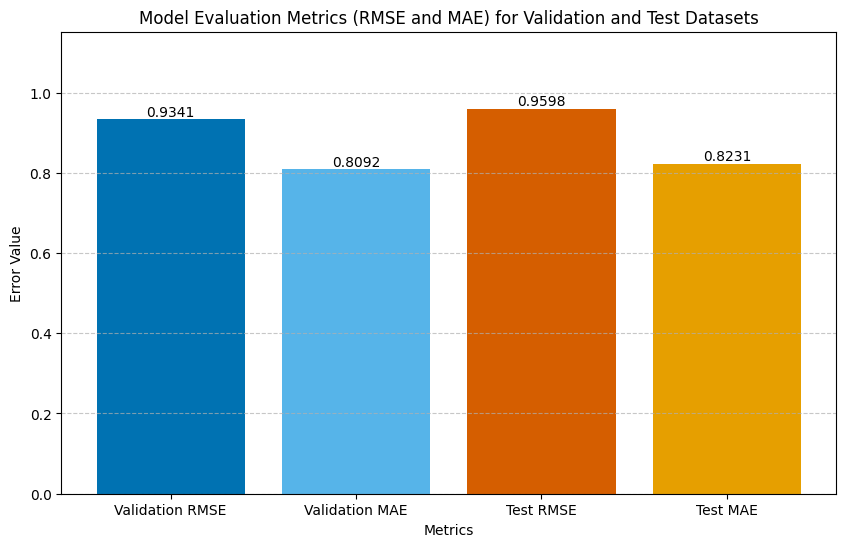

Model Evaluation Metrics (RMSE and MAE) for Validation and Test Datasets:
      Dataset Metric     Value
0  Validation   RMSE  0.934138
1  Validation    MAE  0.809212
2        Test   RMSE  0.959800
3        Test    MAE  0.823150


In [77]:
# Menyimpan metrik evaluasi dalam DataFrame
metrics_data = {
    "Dataset": ["Validation", "Validation", "Test", "Test"],
    "Metric": ["RMSE", "MAE", "RMSE", "MAE"],
    "Value": [rmse_val, mae_val, rmse_test, mae_test]
}
metrics_df = pd.DataFrame(metrics_data)

# Membuat visualisasi RMSE dan MAE untuk dataset val dan test
plt.figure(figsize=(10, 6))
bars = plt.bar(
    metrics_df["Dataset"] + " " + metrics_df["Metric"],
    metrics_df["Value"],
    color=['#0072B2', '#56B4E9', '#D55E00', '#E69F00'],  # Palet warna aman untuk colorblind
)

plt.title("Model Evaluation Metrics (RMSE and MAE) for Validation and Test Datasets")
plt.ylabel("Error Value")
plt.xlabel("Metrics")

# Menentukan batas y-axis secara dinamis
plt.ylim(0, max(metrics_df["Value"]) * 1.2)

# Menambahkan label nilai di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

# Menambahkan grid horizontal untuk mempermudah membaca grafik
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Menampilkan DataFrame untuk referensi
print("Model Evaluation Metrics (RMSE and MAE) for Validation and Test Datasets:")
print(metrics_df)


In [78]:
def precision_at_k(predictions, k=5):
    precision_scores = []

    for user_id, group in predictions.groupby('ReviewerId'):
        top_k = group.nlargest(k, 'predicted_rating')
        relevant_items = top_k[top_k['relevant'] == 1]
        precision_at_k = len(relevant_items) / k
        precision_scores.append(precision_at_k)

    return np.mean(precision_scores)

def recall_at_k(predictions, k=5):
    recall_scores = []

    for user_id, group in predictions.groupby('ReviewerId'):
        top_k = group.nlargest(k, 'predicted_rating')
        relevant_items = top_k[top_k['relevant'] == 1]
        total_relevant = group[group['relevant'] == 1]
        recall_at_k = len(relevant_items) / len(total_relevant) if len(total_relevant) > 0 else 0
        recall_scores.append(recall_at_k)

    return np.mean(recall_scores)

def mse_at_k(predictions, k=5):
    mse_scores = []

    for user_id, group in predictions.groupby('ReviewerId'):
        top_k = group.nlargest(k, 'predicted_rating')
        mse = mean_squared_error(top_k['Rating'], top_k['predicted_rating'])
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Fungsi untuk mendapatkan prediksi dan relevansi
def get_predictions(model_svd, data, train_data, tfidf_matrix_train,
                    tfidf_matrix_val, tfidf_matrix_test):
    predictions = []
    for _, row in data.iterrows():
        predicted_rating = model_svd.predict(row['ReviewerId'], row['PlaceID']).est
        relevance = 1 if row['Rating'] >= 4 else 0
        predictions.append({
            'ReviewerId': row['ReviewerId'],
            'PlaceID': row['PlaceID'],
            'predicted_rating': predicted_rating,
            'Rating': row['Rating'],
            'relevant': relevance
        })
    return pd.DataFrame(predictions)

test_predictions = get_predictions(
    model_svd=model_svd,
    data=test_data,
    train_data=train_data,
    tfidf_matrix_train=tfidf_matrix_train,
    tfidf_matrix_val=tfidf_matrix_val,
    tfidf_matrix_test=tfidf_matrix_test
)

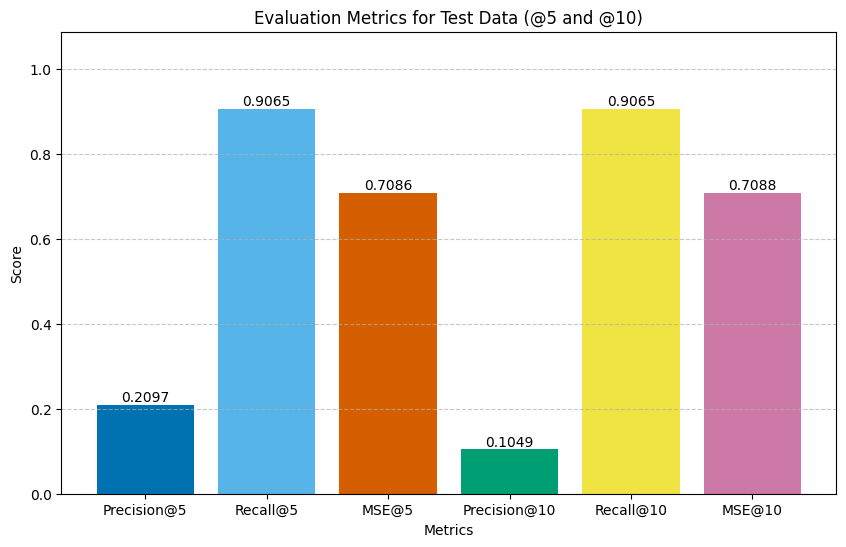

Evaluation Metrics for Test Data (@5 and @10):
         Metric     Value
0   Precision@5  0.209666
1      Recall@5  0.906480
2         MSE@5  0.708633
3  Precision@10  0.104869
4     Recall@10  0.906539
5        MSE@10  0.708769


In [79]:
# Menghitung precision, recall, dan MSE untuk @5 dan @10
precision_5 = precision_at_k(test_predictions, k=5)
recall_5 = recall_at_k(test_predictions, k=5)
mse_5 = mse_at_k(test_predictions, k=5)

precision_10 = precision_at_k(test_predictions, k=10)
recall_10 = recall_at_k(test_predictions, k=10)
mse_10 = mse_at_k(test_predictions, k=10)

# Menyusun data untuk visualisasi
metrics_data = {
    "Metric": ["Precision@5", "Recall@5", "MSE@5", "Precision@10", "Recall@10", "MSE@10"],
    "Value": [precision_5, recall_5, mse_5, precision_10, recall_10, mse_10]
}
metrics_df = pd.DataFrame(metrics_data)

# Visualisasi metrik
plt.figure(figsize=(10, 6))
bars = plt.bar(
    metrics_df["Metric"],
    metrics_df["Value"],
    color=['#0072B2', '#56B4E9', '#D55E00', '#009E73', '#F0E442', '#CC79A7']  # Palet aman untuk colorblind
)

plt.title("Evaluation Metrics for Test Data (@5 and @10)")
plt.ylabel("Score")
plt.xlabel("Metrics")

# Menentukan batas y-axis secara dinamis
plt.ylim(0, max(metrics_df["Value"]) * 1.2)

# Menambahkan label nilai di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

# Menambahkan grid horizontal untuk mempermudah membaca grafik
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Menampilkan DataFrame untuk referensi
print("Evaluation Metrics for Test Data (@5 and @10):")
print(metrics_df)


## Recomendation System Preparation

## Implementation of Hybrid Recomendation CBF for Item based, and CF for User Based

In [80]:
# Variabel untuk menyimpan tempat yang sudah diusulkan
suggested_places = set()

def recommend_places_hybrid(data, model_svd, tfidf_matrix_train,
                            tfidf_matrix_val, tfidf_matrix_test,
                            train_data, alpha=0.1, top_k=5, reference_place=""):
    hybrid_scores = []

    # Filter data berdasarkan nama tempat yang dipilih oleh user
    data_filtered = data[data['Nama_tempat_wisata'] != reference_place]  # Hindari tempat yang dicari

    # Jika tempat yang diminta tidak ada, beri peringatan
    if data_filtered.empty:
        return f"Place '{reference_place}' not found in the dataset."

    # Filter tempat yang sudah disarankan agar tidak muncul lagi
    data_filtered = data_filtered[~data_filtered['Nama_tempat_wisata'].isin(suggested_places)]

    # Loop untuk setiap data yang sudah difilter
    for idx, row in data_filtered.iterrows():
        # Ambil skor CBF dan CF untuk setiap data
        cbf_scores = predict_cbf_scores(data.iloc[idx:idx+1], tfidf_matrix_test, tfidf_matrix_train, train_data)
        cf_scores = predict_cf_scores(data.iloc[idx:idx+1], model_svd)

        # Periksa apakah hasil skor tidak kosong
        if cbf_scores.size > 0 and cf_scores.size > 0:
            # Gabungkan skor CBF dan CF
            hybrid_score = alpha * cbf_scores + (1 - alpha) * cf_scores
            hybrid_scores.append(hybrid_score[0])
        else:
            # Jika ada skor yang kosong, tambahkan skor default (misal 0 atau NaN)
            hybrid_scores.append(0)

    # Tambahkan skor hybrid ke data yang sudah difilter
    data_filtered['hybrid_score'] = hybrid_scores

    # Urutkan berdasarkan skor hybrid dan pilih top_k tempat
    top_recommendations = data_filtered[['PlaceID', 'Nama_tempat_wisata',
                                         'hybrid_score']].sort_values(by='hybrid_score',
                                                                      ascending=False)

    # Hapus duplikasi berdasarkan nama tempat wisata
    top_recommendations = top_recommendations.drop_duplicates(subset='Nama_tempat_wisata')

    # Filter tempat yang sudah direkomendasikan agar tidak muncul lagi
    top_recommendations = top_recommendations[~top_recommendations['Nama_tempat_wisata'].isin(suggested_places)]

    # Pilih top_k tempat (sesuai dengan jumlah yang diminta)
    top_recommendations = top_recommendations.head(top_k)

    # Tambahkan nama tempat yang sudah direkomendasikan ke dalam set suggested_places
    suggested_places.update(top_recommendations['Nama_tempat_wisata'].values)

    # Membuat tabel rekomendasi
    recommendations_df = pd.DataFrame(top_recommendations).reset_index(drop=True)

    # Menampilkan tabel rekomendasi
    return recommendations_df

In [81]:
# Contoh penggunaan dengan input tempat wisata dari user
reference_place = "PASIR PUTIH LUMBAN BULBUL"  # Misalkan user memilih tempat ini
top_k = 10  # Jumlah rekomendasi tempat

# Menjalankan fungsi rekomendasi
recommendations = recommend_places_hybrid(test_data, model_svd, tfidf_matrix_train,
                                           tfidf_matrix_val, tfidf_matrix_test,
                                           train_data, alpha=0.1, top_k=top_k, reference_place=reference_place)

# Menampilkan hasil rekomendasi
print(recommendations)

   PlaceID                                 Nama_tempat_wisata  hybrid_score
0       78  Pusat Informasi Toba Kaldera Unesco Global Geo...      4.461580
1       71                             Pemandian Bukit Gibeon      4.351159
2       62                       Pantai Pasir Putih Parparean      4.347032
3       28      Caldera toba nomadic escape (glamour camping)      4.286767
4       77                          Puncak Panorama Aek Nauli      4.266641
5       39                       Istana Raja Sisingamangaraja      4.263774
6       44               Makam Missonaris Pdt.DR.IL.Nommensen      4.252507
7       47                           Monumen Raja SONAKMALELA      4.245394
8       81                                          Singgolom      4.236768
9       10                        BUKIT GIBEON (YAPIM TARUNA)      4.195499


In [85]:
def recommend_top_places_for_user(data, model_svd, tfidf_matrix_train, tfidf_matrix_val,
                                  tfidf_matrix_test, train_data, user_id, top_k=5, alpha=0.1):
    """
    Menampilkan top_k tempat wisata yang direkomendasikan untuk pengguna berdasarkan model hybrid.

    Parameters:
    - data: DataFrame yang berisi informasi tempat wisata dan rating.
    - model_svd: Model SVD yang sudah dilatih.
    - tfidf_matrix_train: TF-IDF matrix untuk data pelatihan.
    - tfidf_matrix_val: TF-IDF matrix untuk data validasi.
    - tfidf_matrix_test: TF-IDF matrix untuk data pengujian.
    - train_data: DataFrame yang berisi data pelatihan.
    - user_id: ID pengguna yang akan diberikan rekomendasi.
    - top_k: Jumlah tempat wisata teratas yang akan direkomendasikan.
    - alpha: Bobot untuk menggabungkan skor CBF dan CF.

    Returns:
    - DataFrame berisi top_k tempat wisata yang direkomendasikan untuk pengguna.
    """
    # Filter data yang belum ada rating dari pengguna yang dimaksud
    data_filtered = data[~data['ReviewerId'].isin([user_id])]

    # Loop untuk menghitung skor CBF dan CF untuk setiap tempat wisata
    hybrid_scores = []
    for idx, row in data_filtered.iterrows():
        # Ambil skor CBF dan CF untuk setiap data
        cbf_scores = predict_cbf_scores(data.iloc[idx:idx+1], tfidf_matrix_test, tfidf_matrix_train, train_data)
        cf_scores = predict_cf_scores(data.iloc[idx:idx+1], model_svd)

        # Pastikan skor tidak kosong sebelum menggabungkannya
        if cbf_scores.size > 0 and cf_scores.size > 0:
            # Gabungkan skor CBF dan CF
            hybrid_score = alpha * cbf_scores + (1 - alpha) * cf_scores
        else:
            # Jika salah satu skor kosong, tetapkan nilai default (0)
            hybrid_score = 0

        hybrid_scores.append(hybrid_score)

    # Tambahkan skor hybrid ke data yang sudah difilter
    data_filtered['hybrid_score'] = hybrid_scores

    # Urutkan berdasarkan skor hybrid dan pilih top_k tempat
    top_recommendations = data_filtered[['PlaceID', 'Nama_tempat_wisata', 'hybrid_score']].sort_values(by='hybrid_score', ascending=False)

    # Ambil top_k tempat wisata teratas
    top_recommendations = top_recommendations.head(top_k)

    # Kembalikan hasil rekomendasi
    return top_recommendations[['PlaceID', 'Nama_tempat_wisata', 'hybrid_score']]

# Contoh penggunaan
user_target_id = 1554  # Gantilah dengan ID pengguna yang sesuai
top_k = 5  # Jumlah tempat wisata teratas yang akan direkomendasikan

# Mendapatkan rekomendasi tempat wisata untuk pengguna
top_places_for_user = recommend_top_places_for_user(
    data=test_data,
    model_svd=model_svd,
    tfidf_matrix_train=tfidf_matrix_train,
    tfidf_matrix_val=tfidf_matrix_val,
    tfidf_matrix_test=tfidf_matrix_test,
    train_data=train_data,
    user_id=user_target_id,
    top_k=top_k,
    alpha=best_alpha  # Menggunakan alpha terbaik yang ditemukan
)

# Menampilkan hasil rekomendasi
top_places_for_user


<ipython-input-85-e12a9a3c2d8e>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['hybrid_score'] = hybrid_scores


,PlaceID,Nama_tempat_wisata,hybrid_score
1329,78,Pusat Informasi Toba Kaldera Unesco Global Geo...,[4.461580042932946]
1349,78,Pusat Informasi Toba Kaldera Unesco Global Geo...,[4.361854395878895]
135,51,PASIR PUTIH LUMBAN BULBUL,[4.361007576014903]
1905,71,Pemandian Bukit Gibeon,[4.351158790522649]
2905,62,Pantai Pasir Putih Parparean,[4.34703156475459]
